### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE

### Process finetuned embeddings

In [2]:
# Load the embeddings
with open('../data/processed/finetuned_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)
# print(df.head())

# Calculate the mean embedding for each person in each season
grouped = df.groupby(['Person', 'Season'])['Embedding'].apply(
    lambda embeddings: np.mean(np.stack(embeddings), axis=0)
).reset_index()

# Extract the matrix of mean embeddings
embeddings_mean = np.vstack(grouped['Embedding'].values)

### T-SNE plot with all characters

C:\Users\iacop\AppData\Local\Temp\ipykernel_4912\2291408229.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(persons))


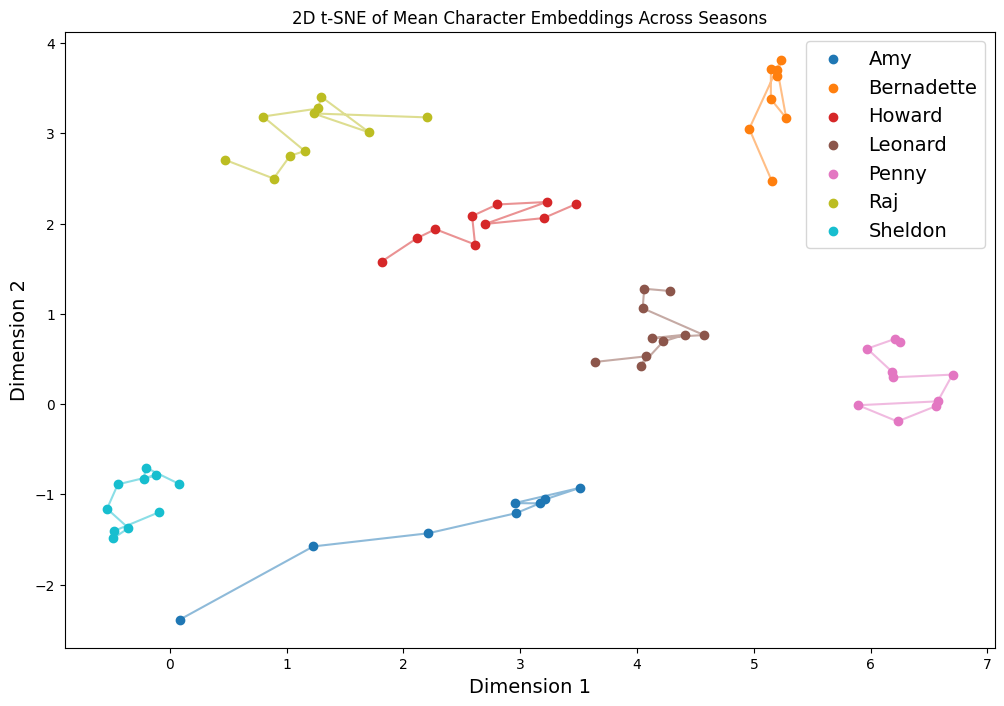

In [3]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_mean)

grouped['x'] = embeddings_2d[:, 0]
grouped['y'] = embeddings_2d[:, 1]


plt.figure(figsize=(12,8))

persons = grouped['Person'].unique()
colors = plt.cm.get_cmap('tab10', len(persons))

for i, person in enumerate(persons):
    sub = grouped[grouped['Person'] == person]
    plt.scatter(sub['x'], sub['y'], label=person, color=colors(i))
    plt.plot(sub['x'], sub['y'], color=colors(i), alpha=0.5)

plt.legend(fontsize=14)
plt.title('2D t-SNE of Mean Character Embeddings Across Seasons')
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)

# Salva PRIMA di plt.show()
plt.savefig('../images/characters_evolution/all_characters.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot of evolution of single characters

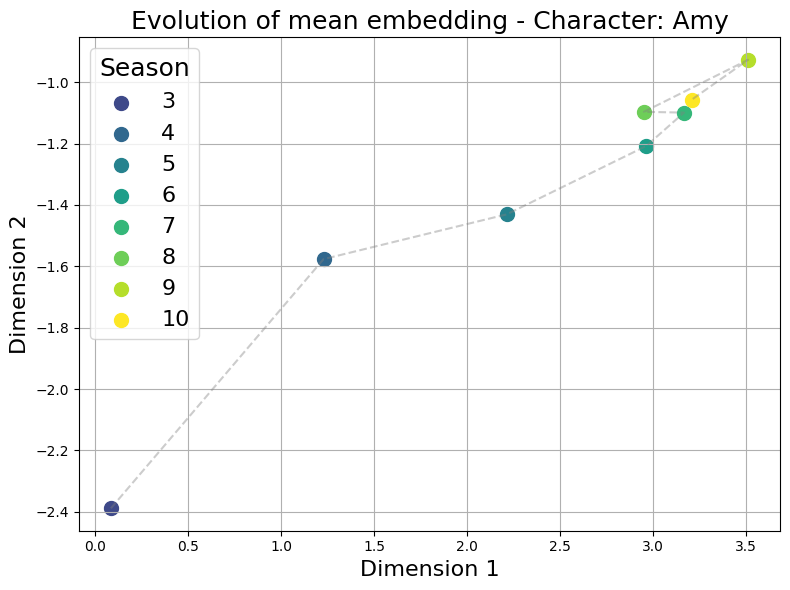

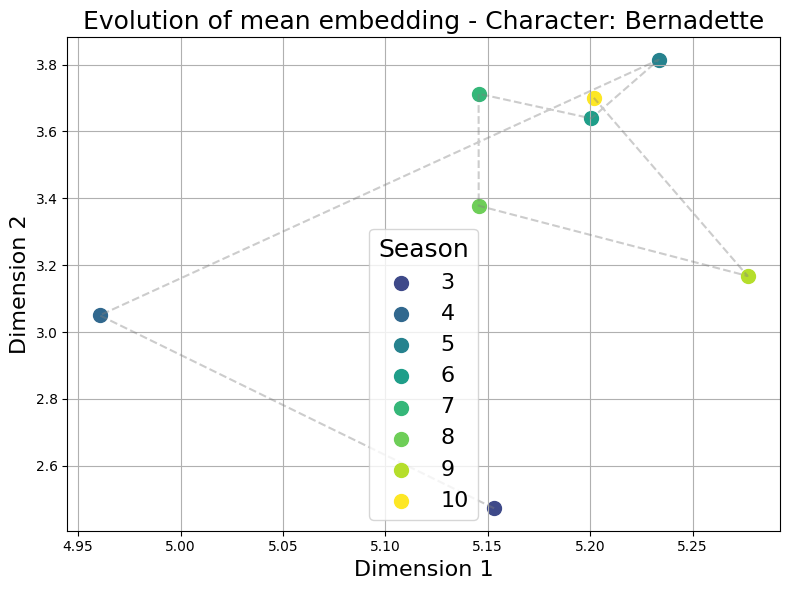

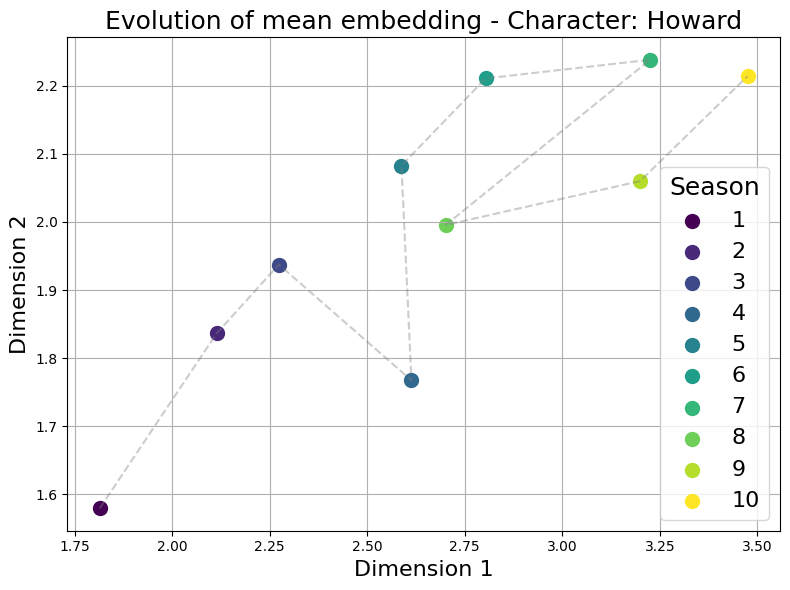

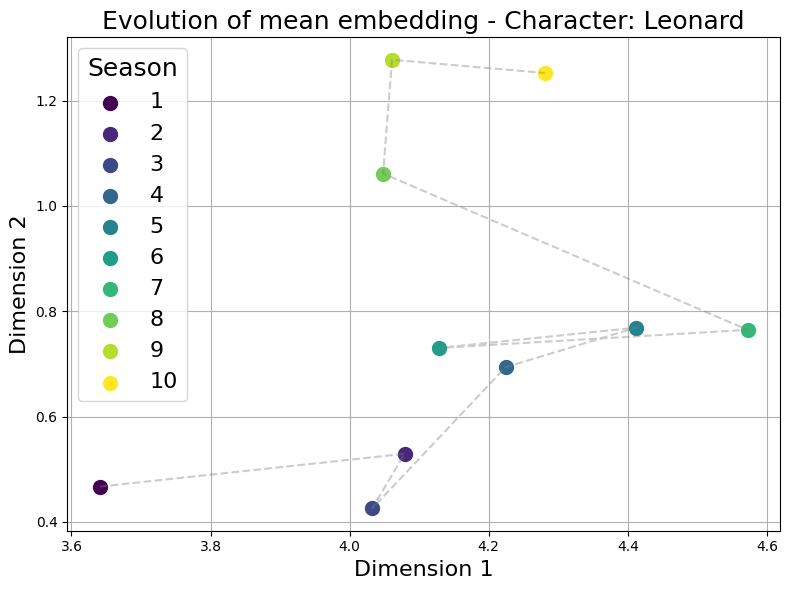

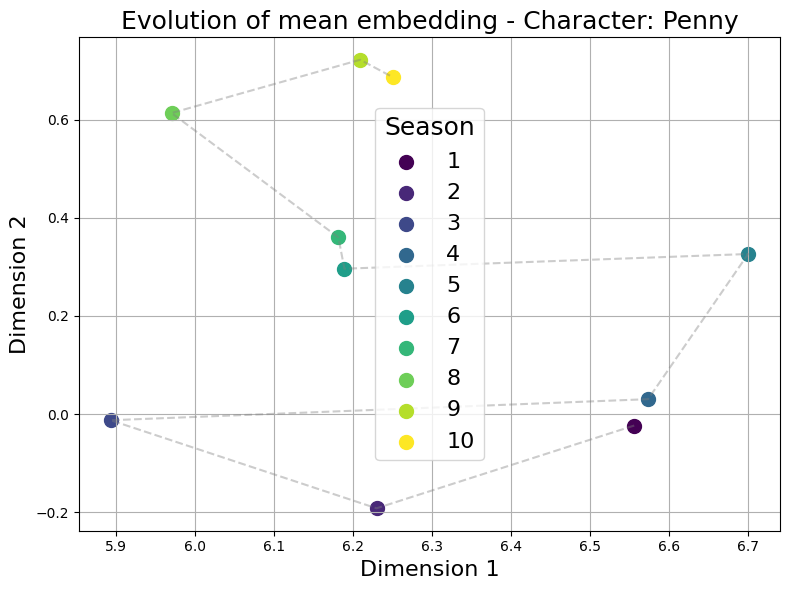

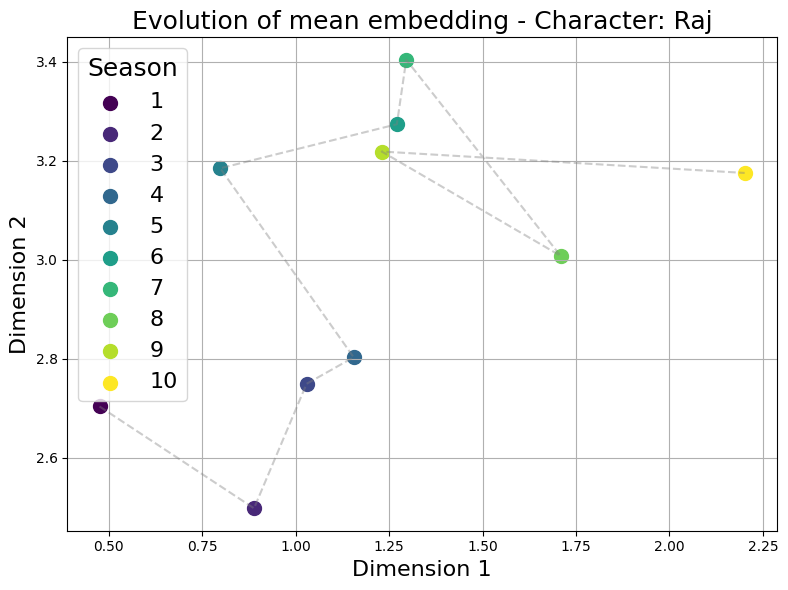

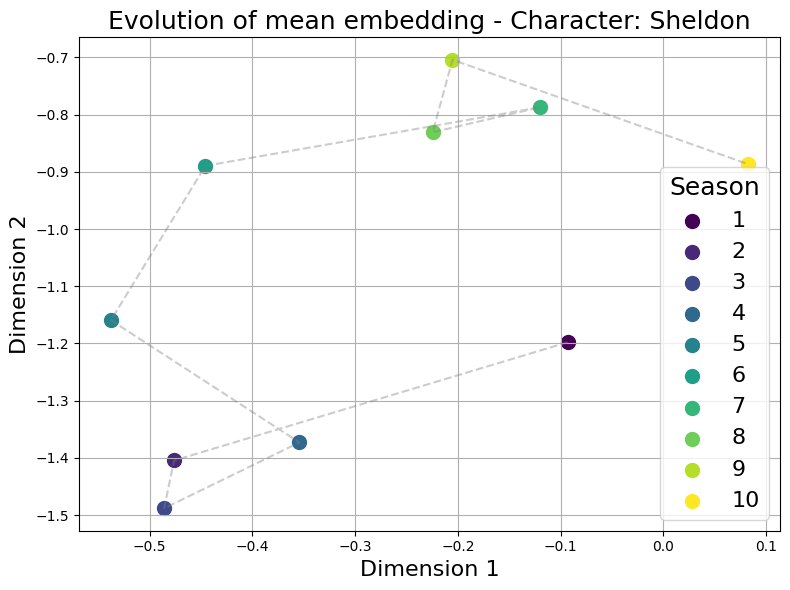

In [4]:
import os

# Ensure the directory exists
os.makedirs('../images/character_evolution', exist_ok=True)

# Order the grouped DataFrame by Person and Season
grouped['Season'] = grouped['Season'].astype(int)
grouped = grouped.sort_values(by=['Person', 'Season'])

# Define colors for each season
unique_seasons = sorted(grouped['Season'].unique())
season_colors = plt.cm.viridis(np.linspace(0,1,len(unique_seasons)))
color_map = {season: color for season, color in zip(unique_seasons, season_colors)}
persons = grouped['Person'].unique()

for person in persons:
    sub = grouped[grouped['Person'] == person]
    plt.figure(figsize=(8,6))
    for season in unique_seasons:
        season_point = sub[sub['Season'] == season]
        if not season_point.empty:
            plt.scatter(season_point['x'], season_point['y'], 
                        color=color_map[season], label=f'{season}', s=100)
    plt.plot(sub['x'], sub['y'], color='gray', alpha=0.4, linestyle='--')
    
    plt.title(f'Evolution of mean embedding - Character: {person}', fontsize=18)
    plt.xlabel('Dimension 1', fontsize=16)
    plt.ylabel('Dimension 2', fontsize=16)
    plt.legend(title='Season', fontsize=16, title_fontsize=18)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'../images/characters_evolution/{person}_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()

### Grids per season of actual cosine distances between characters

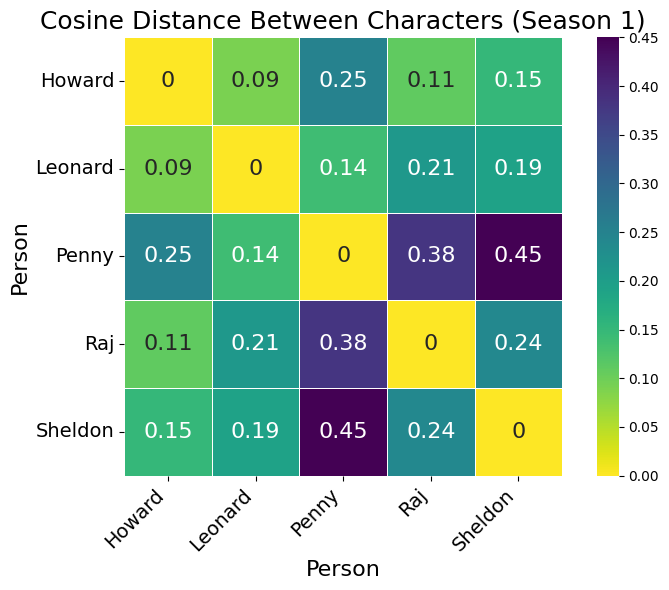

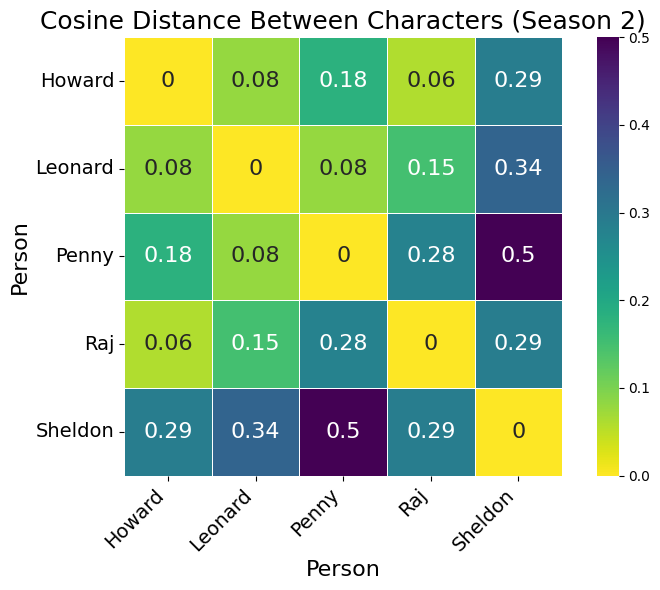

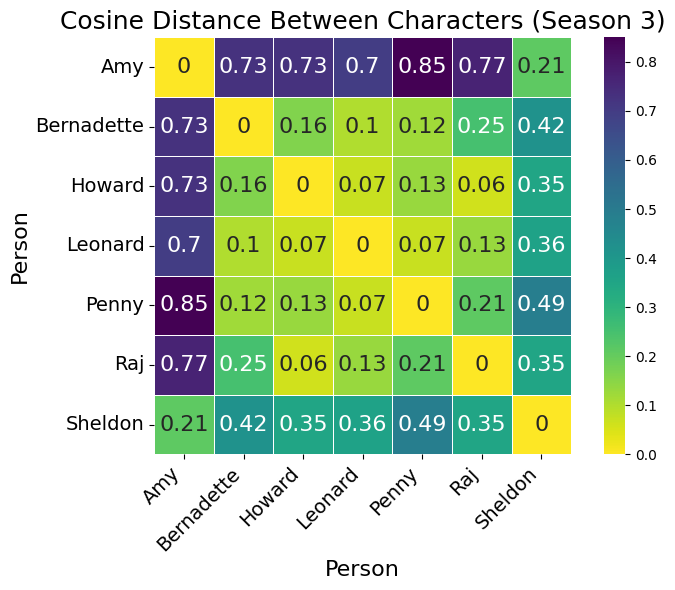

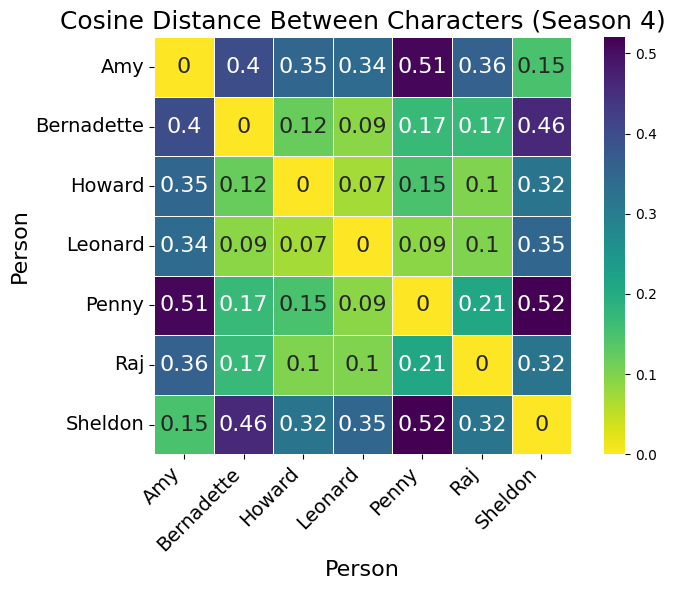

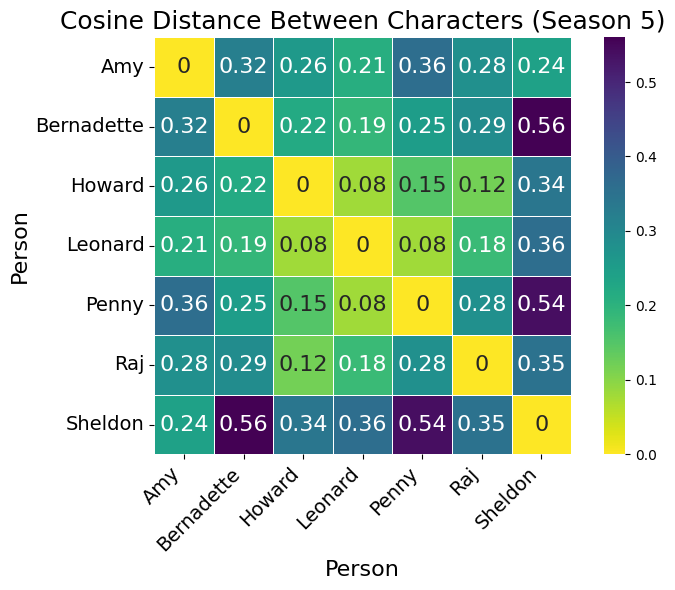

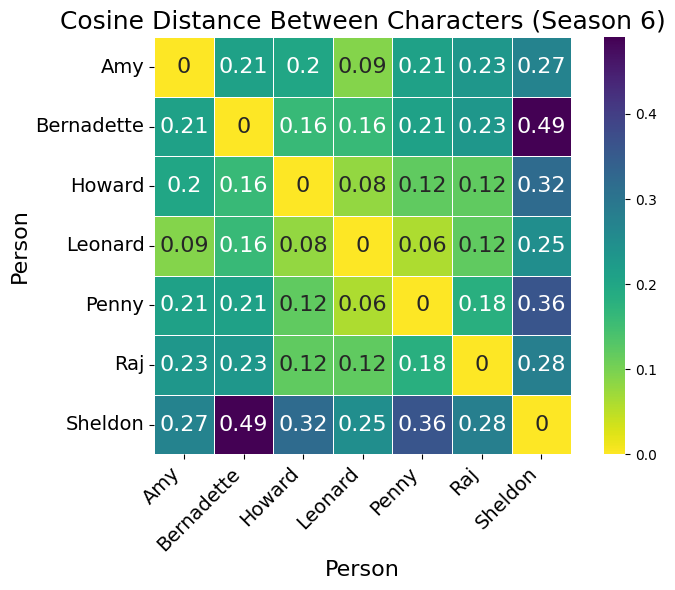

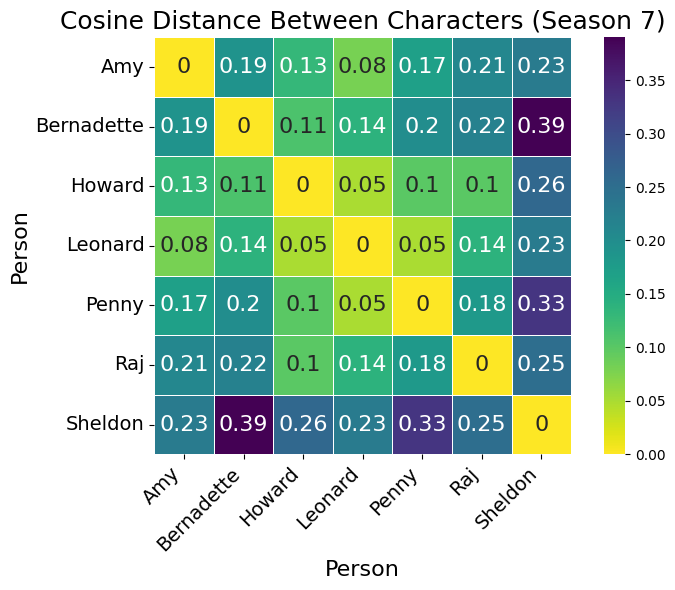

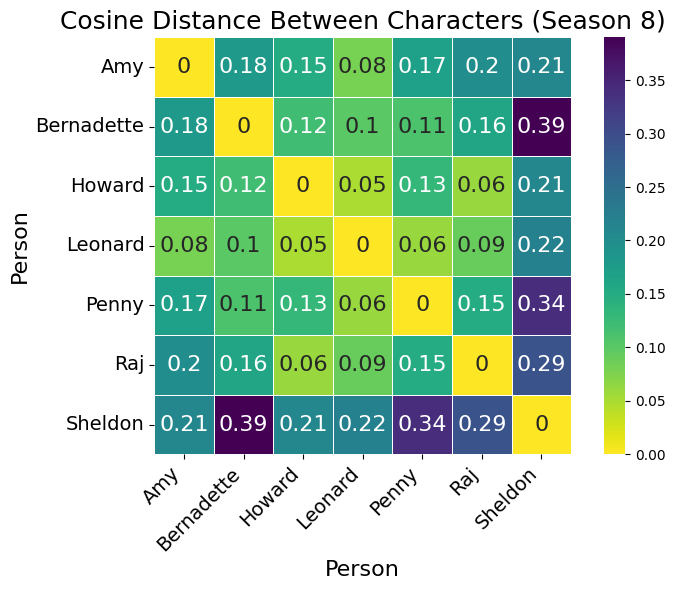

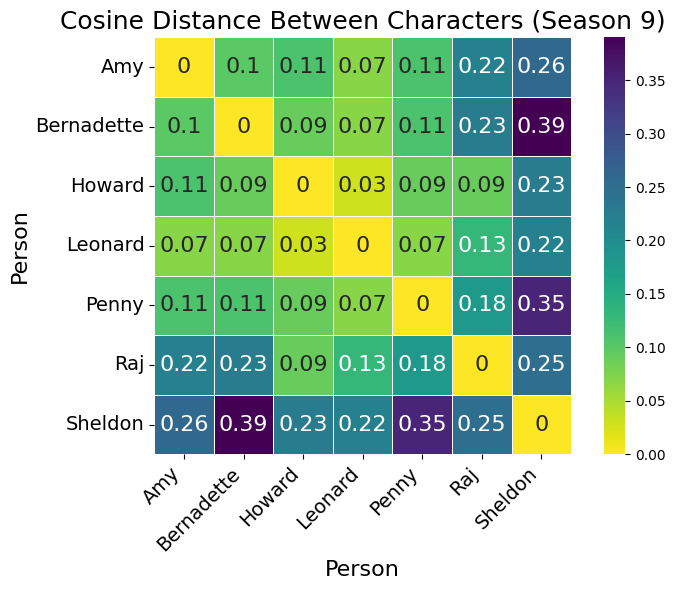

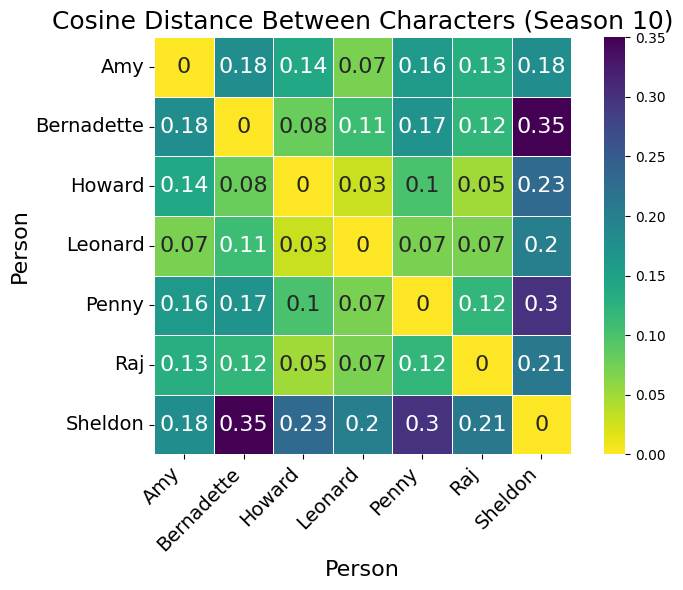

In [5]:
for season in unique_seasons:
	# Filter mean embeddings for this season
	season_df = grouped[grouped['Season'] == season]
	names = season_df['Person'].tolist()
	embeddings = np.vstack(season_df['Embedding'].values)
	
	# Compute cosine distances and round to 2 decimals
	dist = cdist(embeddings, embeddings, metric='cosine')
	np.fill_diagonal(dist, 0)
	dist_rounded = np.round(dist, 2)
	
	plt.figure(figsize=(8, 6))
	ax = sns.heatmap(
		dist_rounded, annot=True, cmap='viridis_r', linewidths=0.5, square=True, cbar=True,
		xticklabels=names, yticklabels=names,
		annot_kws={"size": 16}
	)
	ax.set_title(f'Cosine Distance Between Characters (Season {season})', fontsize=18)
	ax.set_xlabel('Person', fontsize=16)
	ax.set_ylabel('Person', fontsize=16)
	ax.set_xticklabels(names, fontsize=14, rotation=45, ha='right')
	ax.set_yticklabels(names, fontsize=14, rotation=0)
	plt.tight_layout()
	plt.savefig(f'../images/characters_evolution/cosine_distances_season_{season}.png', dpi=300, bbox_inches='tight')
	plt.show()
